In [1]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time
import importlib
import scipy.io as sio
from plot_mi_metric import plot_mi_wrt_clusters

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# choose GPU
torch.cuda.set_device(1)
print(torch.cuda.current_device())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
4
1
cuda


In [3]:
num_clusters = 3

In [4]:
data_dir = './data/wind'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [5]:
data = sio.loadmat(data_dir+'/raw_data/irish_wind_data.mat')['irish_wind_data'][0][0][0].T
print(f'data.shape={data.shape}')
# round figuring the number of observations in a timeseries for the sake of convenience, although not necessary 
data = data[:, :-74]
print(f'data.shape={data.shape}')

data.shape=(12, 6574)
data.shape=(12, 6500)


In [6]:
# number of sensors (to be clustered)
n = data.shape[0]

In [7]:
%%time

import timeseries_dependency_scores as tds
importlib.reload(tds)

# it can be expensive to compute mutual information between every pair of timeseries (167 in this case), which is required for evaluating the clusters, so it's easier to just load it from the data directory
# note that this metric is completely independent in its formulation from the information objective of mutual information for clustering
# this is used only for the purpose for evaluation of clusters from different methods, not for optimizing clusters 
fresh_compute = True

if fresh_compute:
    mi_scores = tds.TimeseriesDependencyScores(metric='mi', num_cores=12).compute_dependency_scores(time_series_data=data)
    np.save(data_dir+'/mi_scores', mi_scores)
else:
    mi_scores = np.load(data_dir+'/mi_scores.npy')

12 6500
............************
CPU times: user 41.8 ms, sys: 123 ms, total: 165 ms
Wall time: 603 ms


In [8]:
plt.rcParams['figure.dpi'] = 80

# kNN clustering

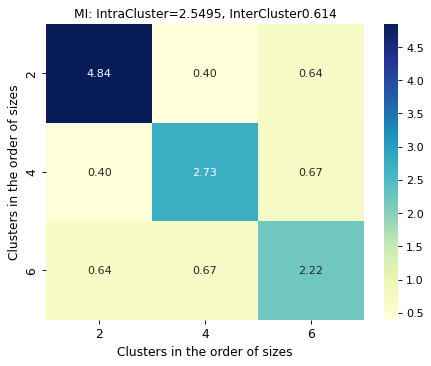

CPU times: user 8min 7s, sys: 25.3 s, total: 8min 32s
Wall time: 3.27 s


In [9]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
kmeans_cluster_labels = ce_obj.cluster_labels_optimize(data=data, cluster_algo='kmeans')

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, kmeans_cluster_labels)

# Spectral clustering

/a/stor125ncs2.virginia.ms.com/sc34972/s182224/venvs/senv/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


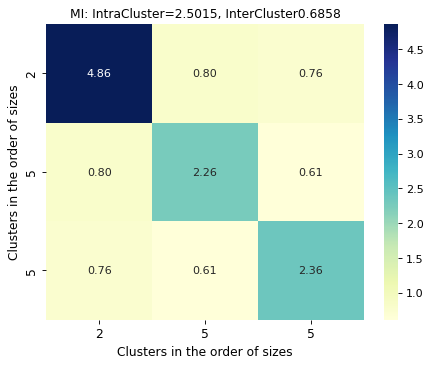

CPU times: user 271 ms, sys: 121 ms, total: 392 ms
Wall time: 203 ms


In [10]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
spectral_cluster_labels = ce_obj.cluster_labels_optimize(data=data, cluster_algo='spectral')

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, spectral_cluster_labels)

# ITC clustering via kNN (using the mutual information objective)

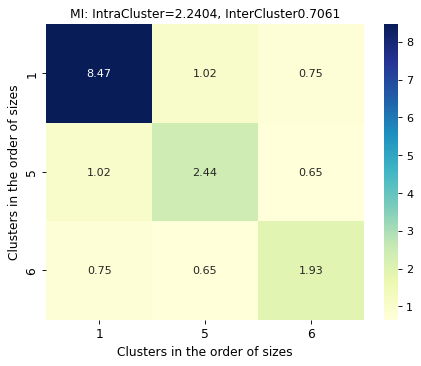

In [11]:
import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
itc_knn_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='itc_knn',
    data=data+1e-100*sampler.rand(data.shape[0], data.shape[1])
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, itc_knn_cluster_labels)

# ITC clustering via minimum spanning tree (using the mutual information objective)

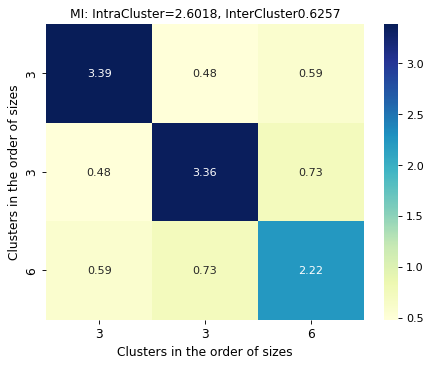

CPU times: user 410 ms, sys: 119 ms, total: 528 ms
Wall time: 334 ms


In [12]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
itc_mst_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='itc_mst',
    data=data+1e-10*sampler.rand(data.shape[0], data.shape[1]),
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, itc_mst_cluster_labels)

# Our ITC-DM approach with LSTMs

....................................................................................................Cluster Sizes [6 6]
....................................................................................................Cluster Sizes [3 6 3]
......

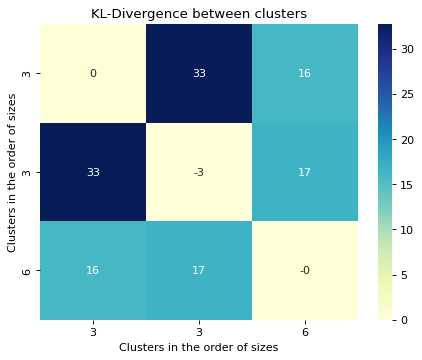

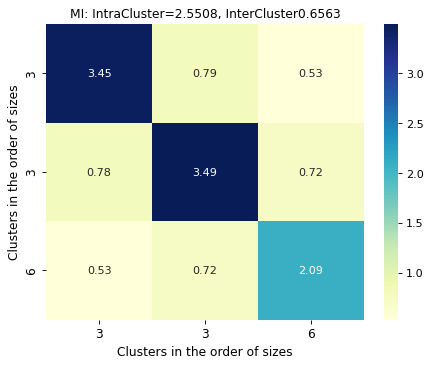

CPU times: user 6.56 s, sys: 1.16 s, total: 7.72 s
Wall time: 4.75 s


In [13]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering(seed=0, debug=False)

cluster_labels_itc_dv_lstm = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
    X_org=data.reshape(data.shape[0], 10, -1),
    is_max_approx=True,
    lr=1e-1,
    num_iter=100,
    cluster_update_prob=1.0,
    std=0.1,
    num_layers=1,
    hidden_size=32,
    num_clusters=num_clusters,
    num_pure_weight_updates=10,
    lr_decay=1.0,
    dropout=0.0,
    nn='lstm',
    device=device,
    debug=False,
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
     X=data.reshape(data.shape[0], 10, -1),
     c=cluster_labels_itc_dv_lstm,
     lr=1e-4,
     num_iter=1000,
     is_max_approx=True,
     std=0.1,
     num_layers=1,
     hidden_size=32,
     dropout=0.0,
     stop_on_zero_self_kl=True,
     device=device,
     debug=False,
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_lstm)

# Our ITC-DM approach with Transformers

....................................................................................................Cluster Sizes [ 1 11]
....................................................................................................Cluster Sizes [1 6 5]
.....

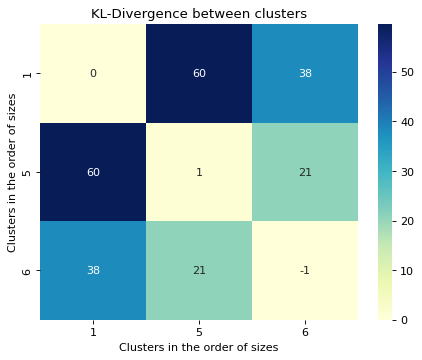

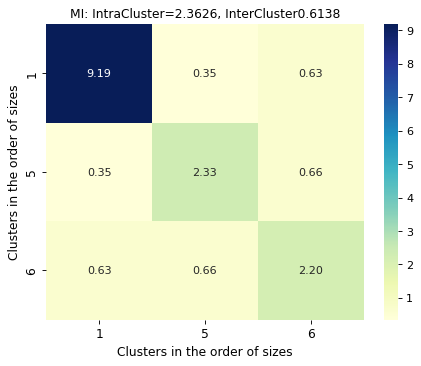

CPU times: user 15.8 s, sys: 665 ms, total: 16.5 s
Wall time: 9.5 s


In [14]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering(seed=0, debug=False)

cluster_labels_itc_dv_transformer = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
    X_org=data.reshape(data.shape[0], 10, -1),
    is_max_approx=True,
    lr=1e-1,
    num_iter=100,
    cluster_update_prob=1.0,
    std=0.1,
    num_layers=3,
    hidden_size=128,
    num_clusters=num_clusters,
    num_pure_weight_updates=10,
    lr_decay=1.0,
    dropout=0.0,
    device=device,
    debug=False,
    nn='transformer',
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
     X=data.reshape(data.shape[0], 10, -1),
     c=cluster_labels_itc_dv_transformer,
     lr=1e-4,
     num_iter=1000,
     is_max_approx=True,
     std=0.1,
     num_layers=1,
     hidden_size=32,
     dropout=0.0,
     stop_on_zero_self_kl=True,
     device=device,
     debug=False,
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_transformer)